# Ch 05 순환신경망 RNN
- feedforward 신경망은 시계열 데이터를 잘 다루지 못한다. 시계열 데이터의 성질(패턴)을 알기 어려움
- 그래서 순환신경망(RNN)을 이용한다. 

In [9]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

## 5.1 확률과 언어모델
- RNN을 위한 준비과정. 자연어에 관한현상을 '확률'을 사용해 기술. 그 후에는 언어를 확률로 다루는 '언어모델'

## 5.1.1 word2vec을 확률 관점에서 바라보기
- w2, w2... wt 라는 단어열로 표현되는 말뭉치가 있다고 가정
- t번째 단어를 '타깃'. (t-1), (t+1)은 맥락으로 취급한다. 

## 5.1.2 언어모델 
- 단어나열에 확률을 부여한다. 특정 단어의 스퀀스에 대해 그 스퀀스가 일어날 가능성이 어느정도인지를 확률로 평가
- 기계번역과 음성인식에 많이 사용된다.
> 음성인식: 음성으로부터 몇개의 문장을 후보로 생성. 언어 모델을 사용하여 후보문장이 자연스러운지를 기준으로 순서를 매긴다. 

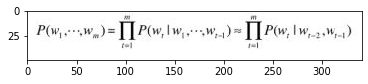

In [9]:
i = imread('5.1.3.jpg')
plt.imshow(i)
plt.show()

- 위의 수식에서는 맥락을 왼쪽 2개 단어로 지정한다. CBOW모델에 따라서 근사적으로 나타낼 수 있다.
 
 ### Markov Chain(Markov model)
- 마크로프 연쇄란 미래의 상태가 현재의 상태에만 의존하여 결정되는 것을 말한다.
- 이사상의 확률이 직전 N개의 사건에만 의존할때, 이를 'N층 markov chain'이라고 한다. 
- 여기에서는 2층 markov chain

### CBOW 모델의 한계
- CBOW: Continuous bag of words 
- 순서가 무시된다, 

# 5.2 RNN (Recurrent Neural Network)

## 5.2.1 순환하는 신경망 
- 순환: 순환을 위해서는 닫힌경로가 필요하다. 
- 데이터의 순환으로 과거의 정보를 기억하는 동시에 최신데이터로 갱신가능. 

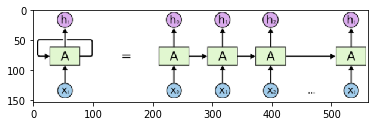

In [14]:
i= imread('RNN.png')
plt.imshow(i)
plt.show()

- xt 를 입력 t는 시각을 뜻한다. 이는 시계열 데이터(x0...xt)가 RNN계층에 입력됨
> xt는 벡터라고 가정한다. 각 단어의 분산표현(단어벡터)이 xt가 되며 RNN에 하나씩 입력된다.
- h0...ht 출력

## 5.2.2 순환구조 펼치기
- 시계열 데이터는 시간방향으로 데이터가 나열.
- 인덱스를 가리킬 때는 '시각' 이라는 용어를 사용한다. >> 시각 t의 단어 혹은 시각 t의 RNN계층

ht = tanh(h(t-1)Wh + xtWx +b)

- Wx: x를 출력 h로 변환하기 위한 가중치
- Wh: RNN의 출력을 다음 시각의 출력으로 변환
- x, h 는 행벡터이다. 
- h는 상태를 가지고 있다. 시각이 1스텝 진행될 때마다 갱신된다.
- ht : hidden state, hidden state vector

## 5.2.3 BPTT: Backpropagation Through Time
- 시간의 크기가 커지면 역전파 시의 기울기가 불안정해진다. 

## 5.2.4 Truncated BPTT
- 큰 시계열 데이터 취급시 적당한 지점에서 잘라내어 작은신경망 여러개로 만든다. 
- 역전파의 연결은 끊어지지만 순전파의 연결은 끊어지면 안된다. 
- 미니배치를 이용 시 [데이터 제공 방법]을 주의해야한다. 

# 5.3 RNN 구현

## 5.3.1 RNN 계층 구현 
- RNN처리를 한단계만 수행하는 클래스부터 구현

In [15]:
class RNN:
    # 초기화 과정
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh), np.zeros_like(b) ]
        self.cache = None
    # 초기화 이후 식을 이용한 코드 
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t= np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
# 식 그대로 구현. 캐시메모리에 저장한것 말고는 동일.
    
    def backward(self, dh_next):
        Wx ,Wh, b = self.params
        x, h_prev, h_next = self.cache
        dt = dh_next * (1 - h_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        return dx, dh_prev

## 5.3.2 Time RNN 계층 구현 
 - T 개의 RNN으로 이루어짐. 
 - RNN계층의 은닉 상태 h를 인스턴스변수로 유지한다. 

In [16]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        # stateful이 True일때 계층은 은닉상태를 유지한다 라는뜻히다. (순전파를 끊지 않고 전파)
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forwar(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers =[]
        hs = np.empty((N, T, H), dtype = 'f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H), dtype = 'f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.appen(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N,T,D), dtype = 'f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        for i, grad in enumerate(grads):
            self.grads[i][...] =grad
        self.dh = dh
        
        return dxs

- forward
 - xs: T개 분량의 시계열 데이터를 하나로 모은것, 
 - N: 미니배치 D: 입력 벡터의 차원 수 > xs의형상은 (N, T, D)
- backward
 - 위로부터의 기울기 dht, 한 시각 뒤 계층으로 부터의 기울기 dh_next
 - 출력이 2개로 분기된다 이는 합산되어 전해진다. 

# 5.4 시계열 데이터 처리 계층 구현 
## 5.4.1 RNNLM(RNN Language Model)

- 가장 아래 층은 Embedding 계층이다. 이 계층은 단어 ID를 단어의 분산표현(단어벡터)로 변환한다. 
- 분산표현이 RNN 계층의 입력으로 들어간다. 
1. RNN 계층은 은닉상태를 다음층으로(위) 출력함과 동시에 다음 시각의 RNN 계층(오른쪽)으로 출력한다. 
2. RNN 계층이 위로 출력한 은닉상태는 Affine 계층을 거쳐 Softmax로 전해지게 된다.

In [17]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f') #Xavier(사비에르) 초깃값 이용
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

## 5.5.2 언어모델의 평가 
- 언어모델은 주어진 과거 단어로부터 다음에 출현할 단어의 확률분포를 출력
- 언어모델의 예측 성능을 평가하는 척도로 'Perplexity'(혼란도)를 자주 이용한다
- perplexity : 확률의 역수 
- perplexity가 1에 가깝다면 다음에 출현할 단어의 후보가 1개. 많을수록 나쁜 모델이라고 볼 수 있다.

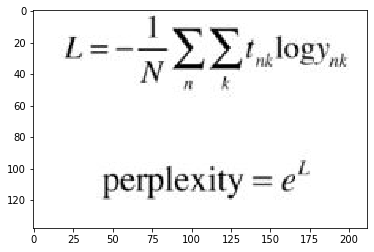

In [12]:
i = imread('5.5.1.jpg')
plt.imshow(i)
plt.show()

1. N: 데이터의 총 개수
2. tn: 원핫 벡터로 나타낸 정답 레이블
3. tnk: n개째 데이터의 k번째 값을 의미한다. 
4. ynk: 확률분포

## 5.5.3 RNNLM의 학습코드 

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 389.82
| 에폭 2 | 퍼플렉서티 256.00
| 에폭 3 | 퍼플렉서티 225.66
| 에폭 4 | 퍼플렉서티 215.82
| 에폭 5 | 퍼플렉서티 208.03
| 에폭 6 | 퍼플렉서티 203.86
| 에폭 7 | 퍼플렉서티 197.93
| 에폭 8 | 퍼플렉서티 196.26
| 에폭 9 | 퍼플렉서티 190.91
| 에폭 10 | 퍼플렉서티 193.07
| 에폭 11 | 퍼플렉서티 188.53
| 에폭 12 | 퍼플렉서티 190.47
| 에폭 13 | 퍼플렉서티 188.62
| 에폭 14 | 퍼플렉서티 188.02
| 에폭 15 | 퍼플렉서티 188.53
| 에폭 16 | 퍼플렉서티 184.67
| 에폭 17 | 퍼플렉서티 181.20
| 에폭 18 | 퍼플렉서티 178.44
| 에폭 19 | 퍼플렉서티 180.76
| 에폭 20 | 퍼플렉서티 182.10
| 에폭 21 | 퍼플렉서티 179.51
| 에폭 22 | 퍼플렉서티 175.53
| 에폭 23 | 퍼플렉서티 170.51
| 에폭 24 | 퍼플렉서티 172.72
| 에폭 25 | 퍼플렉서티 173.30
| 에폭 26 | 퍼플렉서티 170.25
| 에폭 27 | 퍼플렉서티 164.37
| 에폭 28 | 퍼플렉서티 162.16
| 에폭 29 | 퍼플렉서티 161.33
| 에폭 30 | 퍼플렉서티 154.67
| 에폭 31 | 퍼플렉서티 156.68
| 에폭 32 | 퍼플렉서티 149.21
| 에폭 33 | 퍼플렉서티 148.50
| 에폭 34 | 퍼플렉서티 144.68
| 에폭 35 | 퍼플렉서티 145.33
| 에폭 36 | 퍼플렉서티 137.07
| 에폭 37 | 퍼플렉서티 134.54
| 에폭 38 | 퍼플렉서티 131.52
| 에폭 39 | 퍼플렉서티 128.44
| 에폭 40 | 퍼플렉서티 121.05
| 에폭 41 | 퍼플렉서티 121.24
| 에폭 42 | 퍼플렉서티 114.91
| 에폭 43 | 퍼플렉서티 109

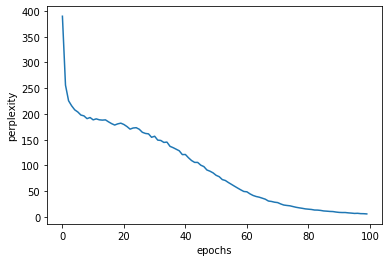

In [18]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()